# Лабораторная работа №1 "Проведение исследований с алгоритмом KNN"

### Обоснование выбранных датасетов

**Датасет классификации**

Датасет представляет собой набор различных характеристик музыкальных композиций (название, автор, темп, тональность и пр.). По этим характеристикам планируется классифицировать композиции по жанрам.

**Датасет регрессии**

Датасет представляет собор набор характеристик, связанных с магазинами Walmart. По ним планируется предугадать сумму недельных продаж магазинов (последние 20% дат)

### Ход работы

Импортируем библиотеки перед работой

In [44]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, KFold, GroupKFold
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

##### Создание бейзлайна для модели классификации

Загрузим данные

In [5]:
c_base_df = pd.read_csv("../classification.csv").sample(frac=1, random_state=42).reset_index(drop=True)
c_base_df.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,24735.0,The Dead Weather,Bone House,25.0,0.007730,0.530,206800.0,0.896,0.003030,G,0.0833,-5.489,Major,0.1370,123.602,4-Apr,0.243,Blues
1,41022.0,ZAQ,Last Proof - Instrumental,14.0,0.000015,0.378,284413.0,0.846,0.746000,G#,0.0681,-5.435,Minor,0.0609,195.885,4-Apr,0.527,Anime
2,69676.0,!!!,Californiyeah,36.0,0.024900,0.865,274013.0,0.650,0.000391,A,0.1020,-8.025,Minor,0.1010,120.03,4-Apr,0.557,Electronic
3,71071.0,Norah Jones,Lonestar,52.0,0.888000,0.642,186080.0,0.139,0.000014,C,0.3380,-14.776,Major,0.0306,89.88,4-Apr,0.332,Jazz
4,39042.0,Greta Van Fleet,Rolling In The Deep - Recorded At Spotify Stud...,64.0,0.005700,0.615,237653.0,0.487,0.002990,B,0.0995,-10.089,Minor,0.0269,104.986,4-Apr,0.323,Rock


Выполним предобработку данных. Сначал удалим ненужные фичи, такие как идентификатор, дату получения данных, название трека и его автора.

In [6]:
c_base_df = c_base_df.drop(columns=['instance_id', 'obtained_date', 'track_name', 'artist_name'])

Также удалим повторяющиеся записи

In [7]:
c_base_df.drop_duplicates()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,25.0,0.007730,0.530,206800.0,0.896,0.003030,G,0.0833,-5.489,Major,0.1370,123.602,0.243,Blues
1,14.0,0.000015,0.378,284413.0,0.846,0.746000,G#,0.0681,-5.435,Minor,0.0609,195.885,0.527,Anime
2,36.0,0.024900,0.865,274013.0,0.650,0.000391,A,0.1020,-8.025,Minor,0.1010,120.03,0.557,Electronic
3,52.0,0.888000,0.642,186080.0,0.139,0.000014,C,0.3380,-14.776,Major,0.0306,89.88,0.332,Jazz
4,64.0,0.005700,0.615,237653.0,0.487,0.002990,B,0.0995,-10.089,Minor,0.0269,104.986,0.323,Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,43.0,0.071700,0.513,265665.0,0.763,0.919000,F#,0.1640,-7.425,Minor,0.0570,?,0.532,Jazz
49996,42.0,0.024100,0.276,415920.0,0.726,0.818000,C#,0.0927,-6.678,Minor,0.0469,73.584,0.272,Classical
49997,64.0,0.458000,0.400,109707.0,0.818,0.000003,C,0.1320,-11.238,Major,0.0800,166.287,0.936,Rock
49998,27.0,0.110000,0.523,228706.0,0.904,0.269000,G#,0.2910,-3.038,Minor,0.6080,?,0.511,Electronic


Обратим внимание на типы данных в датафрейме.

In [8]:
c_base_df.dtypes

popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo                object
valence             float64
music_genre          object
dtype: object

Переопределим типы там, где это нужно, а также обработаем категориальные фичи

In [9]:
c_base_df['tempo'] = pd.to_numeric(c_base_df['tempo'], errors='coerce')

le = LabelEncoder()
c_base_df['mode'] = le.fit_transform(c_base_df['mode'])
c_base_df['music_genre'] = le.fit_transform(c_base_df['music_genre'])
c_base_df['key'] = le.fit_transform(c_base_df['key'])


Теперь проведем анализ пустых значений.

In [10]:
print(c_base_df[c_base_df.isna().any(axis=1)])
print(c_base_df.columns[c_base_df.isna().any()].tolist())

       popularity  acousticness  danceability  duration_ms  energy  \
17           35.0      0.329000         0.602     280293.0   0.473   
23           38.0      0.000537         0.495     212613.0   0.895   
29           33.0      0.872000         0.655     283107.0   0.185   
30           55.0      0.003750         0.513     211720.0   0.823   
33           36.0      0.292000         0.729     407920.0   0.906   
...           ...           ...           ...          ...     ...   
49961        31.0      0.774000         0.195     257933.0   0.126   
49964        37.0      0.459000         0.790     182667.0   0.864   
49981        52.0      0.148000         0.327         -1.0   0.816   
49995        43.0      0.071700         0.513     265665.0   0.763   
49998        27.0      0.110000         0.523     228706.0   0.904   

       instrumentalness  key  liveness  loudness  mode  speechiness  tempo  \
17             0.010900    7    0.1100    -6.623     1       0.0296    NaN   
23 

Только поле tempo содержит Nan. Пока что просто заменим это значение медианой, т.к. из-за этого модель будет более устойчивой к выбросам.

In [11]:
median_tempo = c_base_df['tempo'].median()
c_base_df['tempo'] = c_base_df['tempo'].fillna(median_tempo)

c_base_df.head(10)

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,25.0,0.007730,0.530,206800.0,0.8960,0.003030,10,0.0833,-5.489,0,0.1370,123.602,0.243,2
1,14.0,0.000015,0.378,284413.0,0.8460,0.746000,11,0.0681,-5.435,1,0.0609,195.885,0.527,1
2,36.0,0.024900,0.865,274013.0,0.6500,0.000391,0,0.1020,-8.025,1,0.1010,120.030,0.557,5
3,52.0,0.888000,0.642,186080.0,0.1390,0.000014,3,0.3380,-14.776,0,0.0306,89.880,0.332,7
4,64.0,0.005700,0.615,237653.0,0.4870,0.002990,2,0.0995,-10.089,1,0.0269,104.986,0.323,9
5,24.0,0.992000,0.391,222560.0,0.0667,0.892000,4,0.1130,-20.221,0,0.0610,138.059,0.537,3
6,32.0,0.652000,0.304,202896.0,0.5510,0.000419,4,0.1300,-12.323,0,0.0861,98.302,0.157,7
7,56.0,0.059000,0.939,188067.0,0.6890,0.000000,3,0.0895,-5.121,0,0.0877,137.050,0.502,6
8,56.0,0.041800,0.621,227973.0,0.8850,0.492000,4,0.1330,-6.826,0,0.0473,109.727,0.554,5
9,56.0,0.156000,0.442,261453.0,0.7410,0.000000,0,0.4110,-5.338,1,0.1820,103.425,0.342,9


Подготовим данные к обучению и обучим модель на этих данных

In [12]:
X_c_base = c_base_df.drop(columns=["music_genre"])
y_c_base = c_base_df["music_genre"]

X_c_base_train, X_c_base_test, y_c_base_train, y_c_base_test = train_test_split(
    X_c_base,
    y_c_base,
    test_size=0.2,
    random_state=42,
    stratify=y_c_base
)


In [55]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_c_base_train, y_c_base_train)
y_pred = knn.predict(X_c_base_test)

accuracy_score(y_c_base_test, y_pred)

0.1741

Как и ожидалось, был получен маленький скор

##### Улучшение бейзлайна для модели классификации

Проанализируем отчёт по обученной модели

In [56]:
print(classification_report(y_c_base_test, y_pred))

              precision    recall  f1-score   support

           0       0.12      0.25      0.16      1000
           1       0.24      0.30      0.27      1000
           2       0.13      0.15      0.14      1000
           3       0.33      0.27      0.30      1000
           4       0.16      0.16      0.16      1000
           5       0.17      0.15      0.16      1000
           6       0.16      0.13      0.14      1000
           7       0.16      0.11      0.13      1000
           8       0.18      0.12      0.14      1000
           9       0.17      0.11      0.13      1000

    accuracy                           0.17     10000
   macro avg       0.18      0.17      0.17     10000
weighted avg       0.18      0.17      0.17     10000



Из этого можно сделать вывод, что некоторые классы предсказываются хуже, а некоторые - лучше. Держим в голове то, что записей с каждым жанром было поровну

In [57]:
y_c_base.value_counts()

music_genre
2    5000
1    5000
5    5000
7    5000
9    5000
3    5000
6    5000
0    5000
8    5000
4    5000
Name: count, dtype: int64

Посмотрим матрицу корреляций

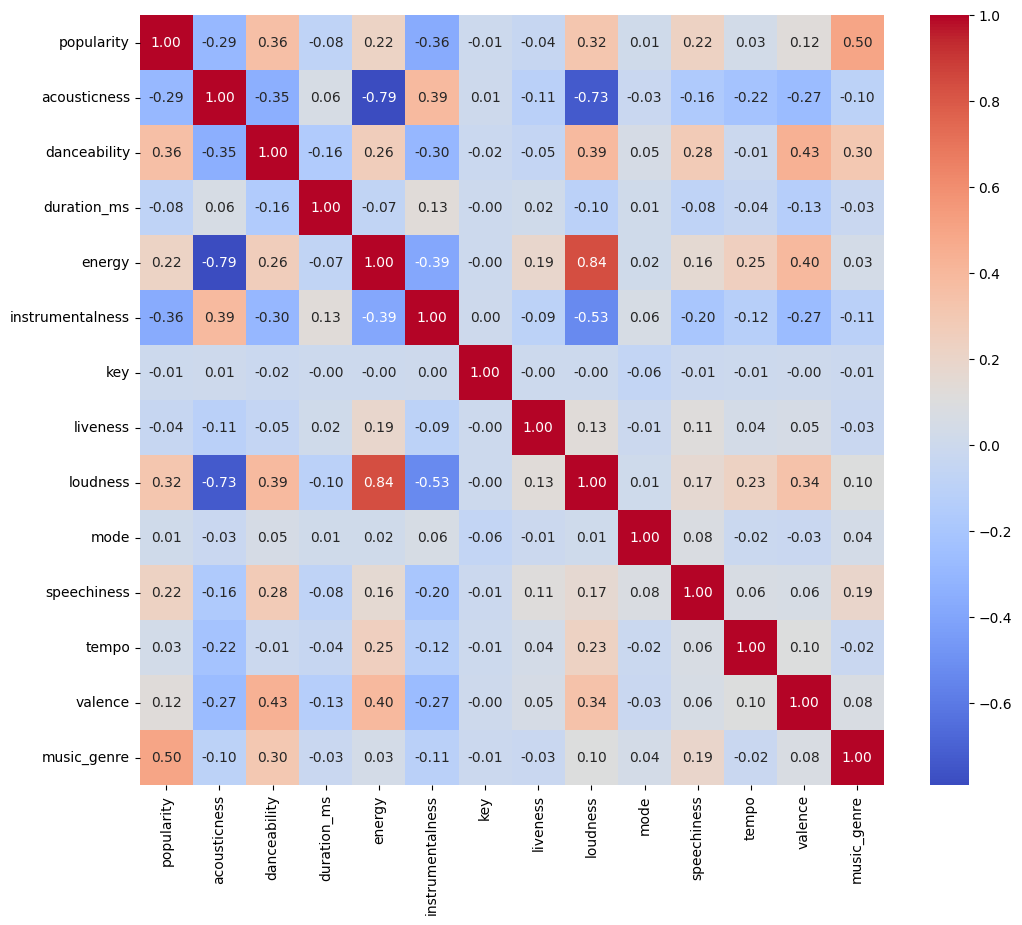

In [58]:
corr_matrix = c_base_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

Как можно заметить, есть сильная корреляция между фичами loudness, energy и acousticness, что, в принципе, логично. Попробуем разбить их по PCA. Здесь же и начнём построение новых данных для обучения

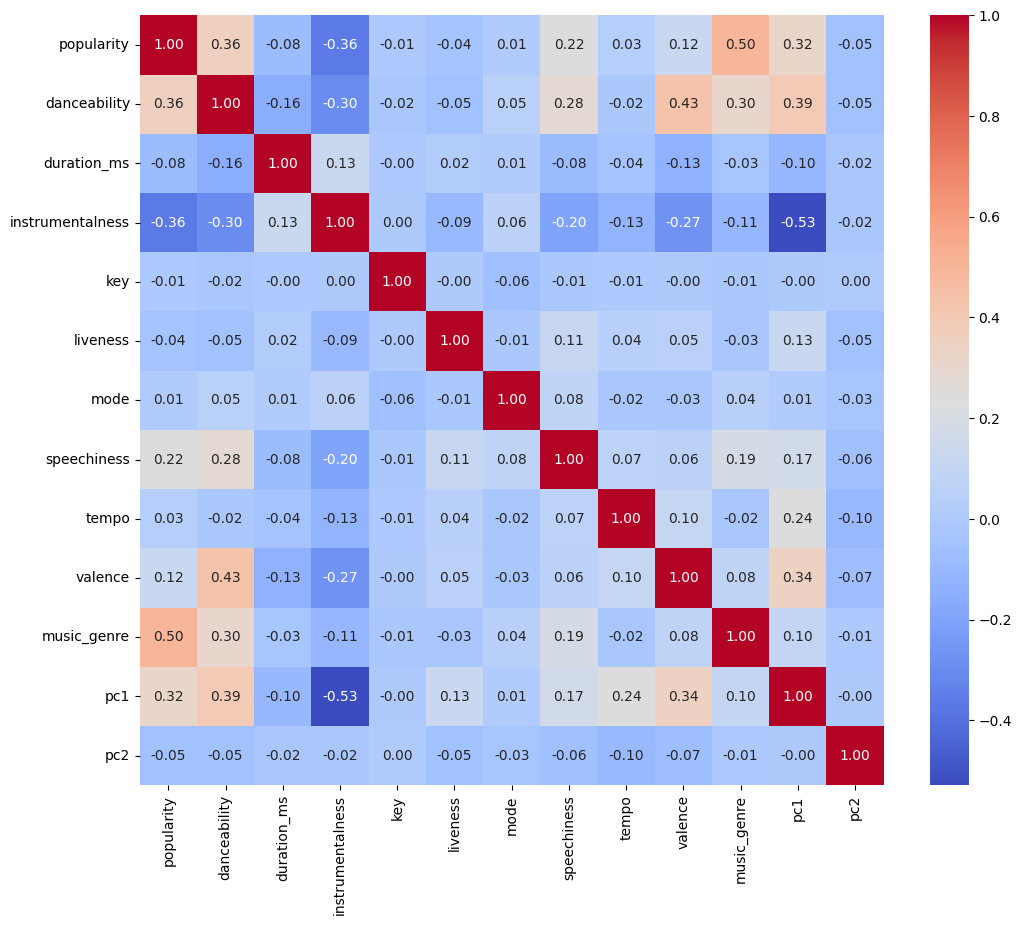

In [24]:
c_df = pd.read_csv("../classification.csv").sample(frac=1, random_state=42).reset_index(drop=True)

c_df = c_df.drop(columns=['instance_id', 'obtained_date', 'track_name', 'artist_name'])

pca = PCA(n_components=2)
c_df[['pc1', 'pc2']] = pca.fit_transform(c_df[['loudness', 'acousticness', 'energy']])
c_df = c_df.drop(columns=['loudness', 'acousticness', 'energy'])

c_df['tempo'] = pd.to_numeric(c_df['tempo'], errors='coerce')

le = LabelEncoder()
c_df['mode'] = le.fit_transform(c_df['mode'])
c_df['music_genre'] = le.fit_transform(c_df['music_genre'])
c_df['key'] = le.fit_transform(c_df['key'])

corr_matrix = c_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


Теперь обратим внимание на duration_ms

/tmp/ipython-input-1440364930.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


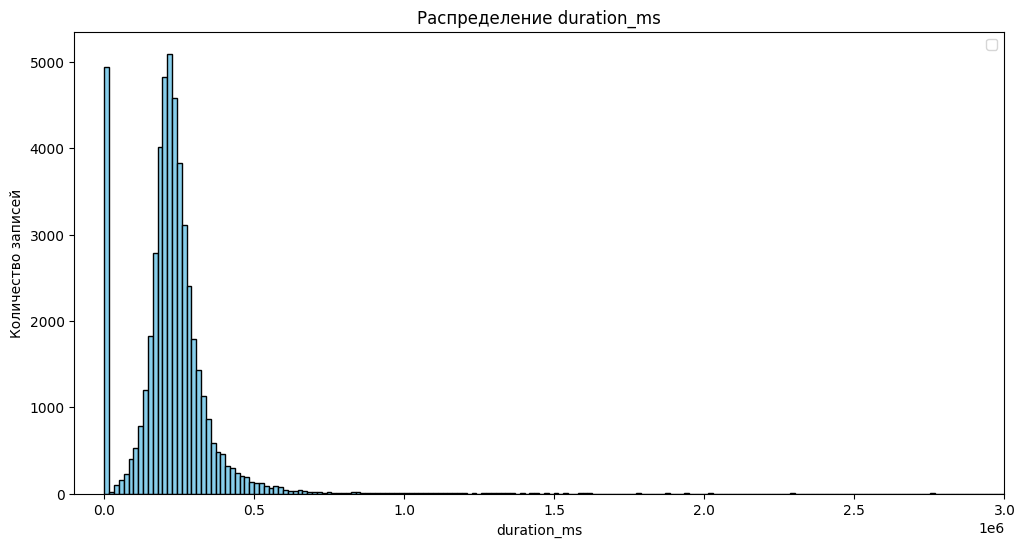

In [ ]:
plt.figure(figsize=(12, 6))

plt.hist(c_df['duration_ms'], bins=300, color='skyblue', edgecolor='black')

plt.title('Распределение duration_ms')
plt.xlabel('duration_ms')
plt.ylabel('Количество записей')
plt.legend()
plt.xlim(-100000, 3e6)
plt.show()


/tmp/ipython-input-1114621962.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


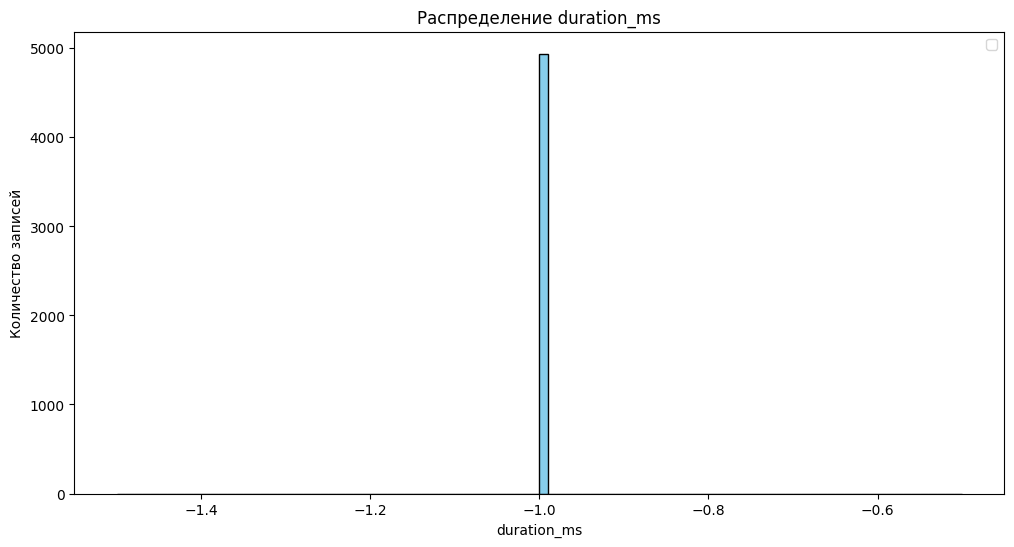

In [ ]:
plt.figure(figsize=(12, 6))

plt.hist(c_df[(c_df['duration_ms'] >= -100) & (c_df['duration_ms'] <= 100)]['duration_ms'], bins=100, color='skyblue', edgecolor='black')

plt.title('Распределение duration_ms')
plt.xlabel('duration_ms')
plt.ylabel('Количество записей')
plt.legend()
plt.show()

Будем считать, что это неопределённые значения длительности композиции.

In [25]:
c_df['duration_ms'] = c_df['duration_ms'].replace(-1, np.nan)

Также просмотрим остальные фичи на наличие подобных выбросов

/tmp/ipython-input-622616021.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


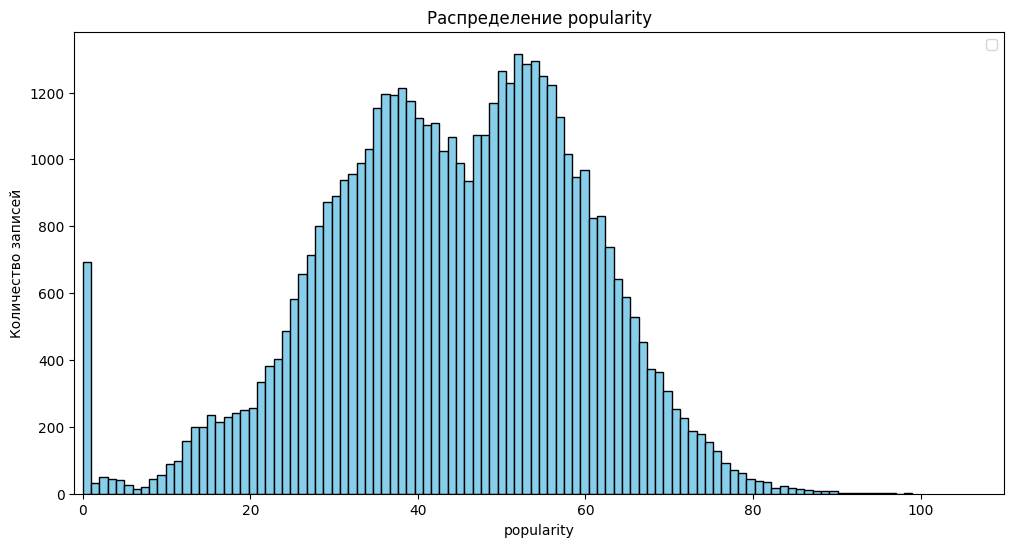

In [ ]:
plt.figure(figsize=(12, 6))

plt.hist(c_df['popularity'], bins=100, color='skyblue', edgecolor='black')

plt.title('Распределение popularity')
plt.xlabel('popularity')
plt.ylabel('Количество записей')
plt.legend()
plt.xlim(-1, 110)
plt.show()

In [ ]:
c_df[c_df['popularity'] == 0]['music_genre'].value_counts()

,count
music_genre,
3,541
4,41
2,31
5,27
7,27
1,21
0,5
9,1


/tmp/ipython-input-3000786691.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


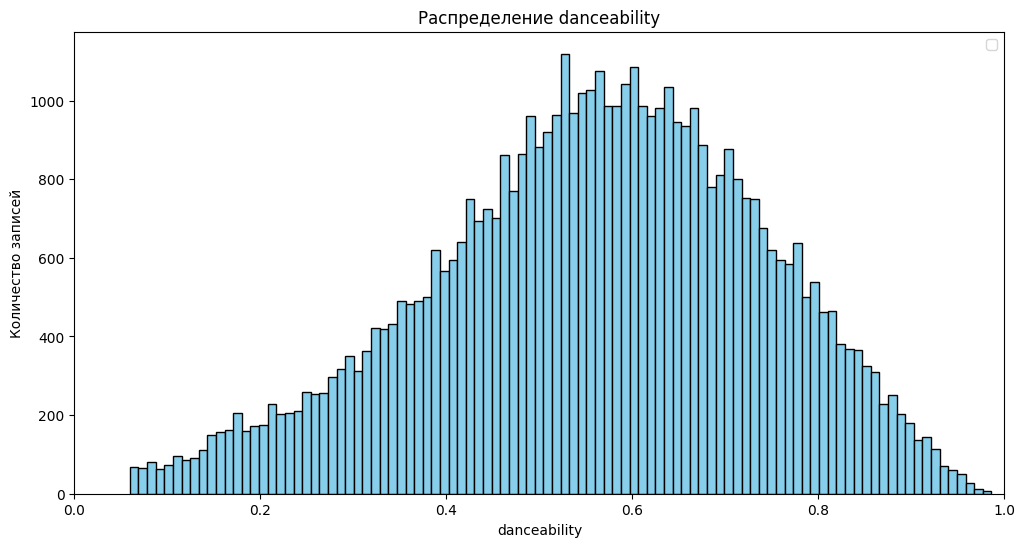

In [ ]:
plt.figure(figsize=(12, 6))

plt.hist(c_df['danceability'], bins=100, color='skyblue', edgecolor='black')

plt.title('Распределение danceability')
plt.xlabel('danceability')
plt.ylabel('Количество записей')
plt.legend()
plt.xlim(0, 1)
plt.show()

/tmp/ipython-input-993346692.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


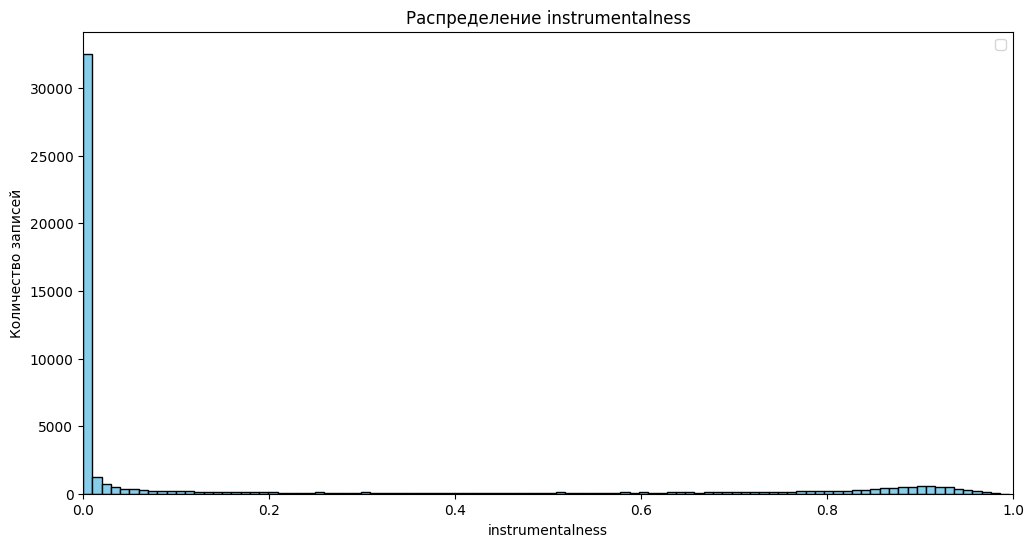

In [ ]:
plt.figure(figsize=(12, 6))

plt.hist(c_df['instrumentalness'], bins=100, color='skyblue', edgecolor='black')

plt.title('Распределение instrumentalness')
plt.xlabel('instrumentalness')
plt.ylabel('Количество записей')
plt.legend()
plt.xlim(0, 1)
plt.show()

/tmp/ipython-input-2131038927.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


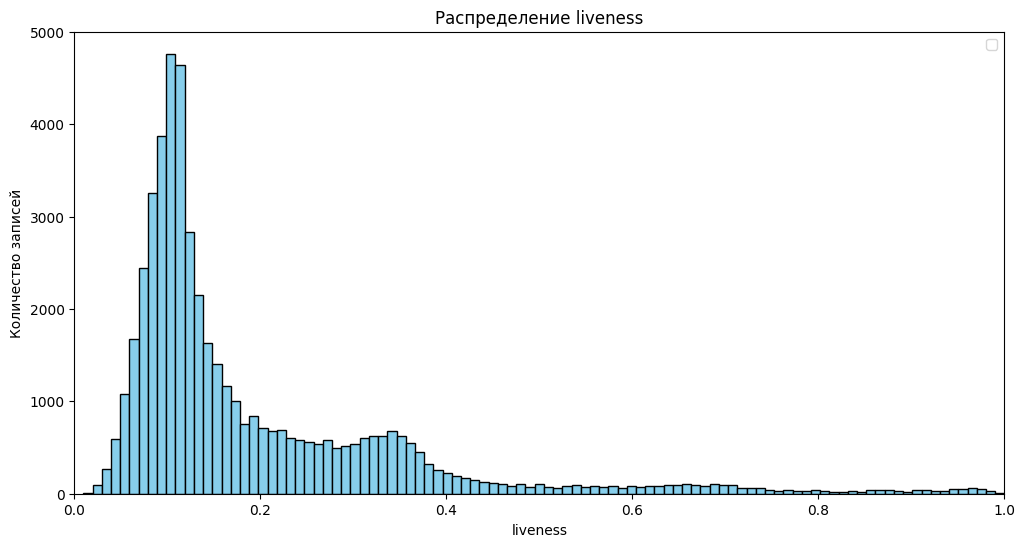

In [ ]:
plt.figure(figsize=(12, 6))

plt.hist(c_df['liveness'], bins=100, color='skyblue', edgecolor='black')

plt.title('Распределение liveness')
plt.xlabel('liveness')
plt.ylabel('Количество записей')
plt.legend()
plt.xlim(0, 1)
plt.show()

/tmp/ipython-input-3615637157.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


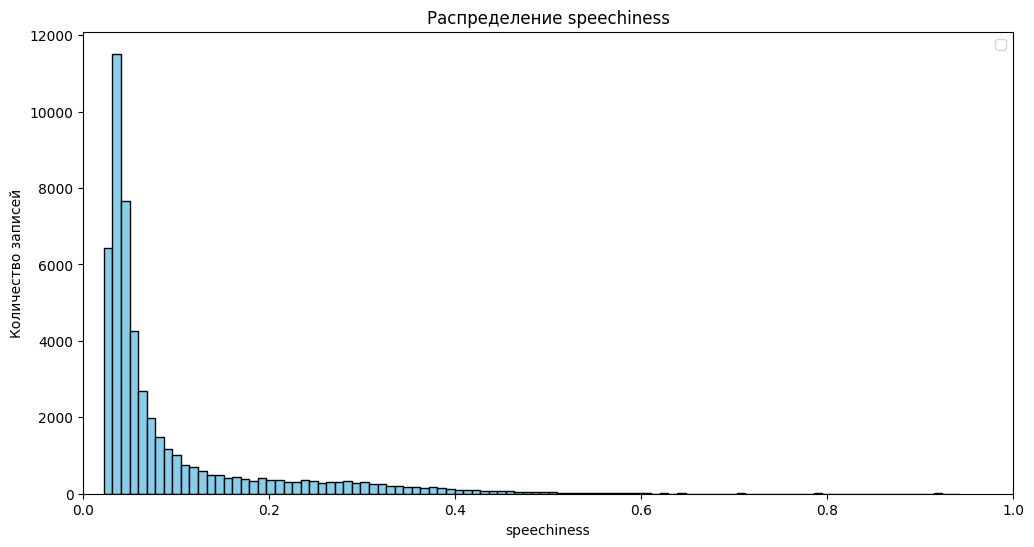

In [ ]:
plt.figure(figsize=(12, 6))

plt.hist(c_df['speechiness'], bins=100, color='skyblue', edgecolor='black')

plt.title('Распределение speechiness')
plt.xlabel('speechiness')
plt.ylabel('Количество записей')
plt.legend()
plt.xlim(0, 1)
plt.show()

/tmp/ipython-input-3497167798.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


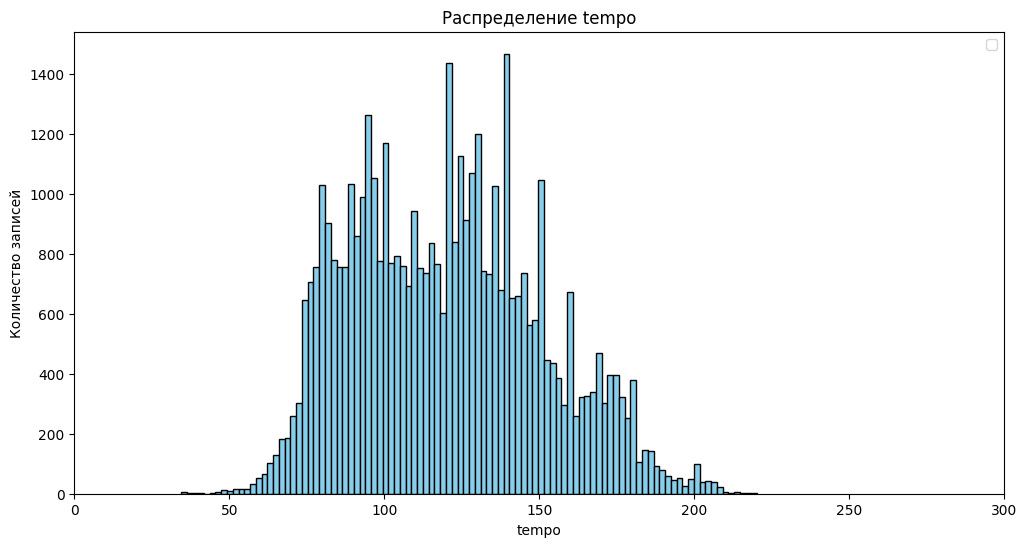

In [ ]:
plt.figure(figsize=(12, 6))

plt.hist(c_df['tempo'], bins=100, color='skyblue', edgecolor='black')

plt.title('Распределение tempo')
plt.xlabel('tempo')
plt.ylabel('Количество записей')
plt.legend()
plt.xlim(0, 300)
plt.show()

/tmp/ipython-input-2447615085.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


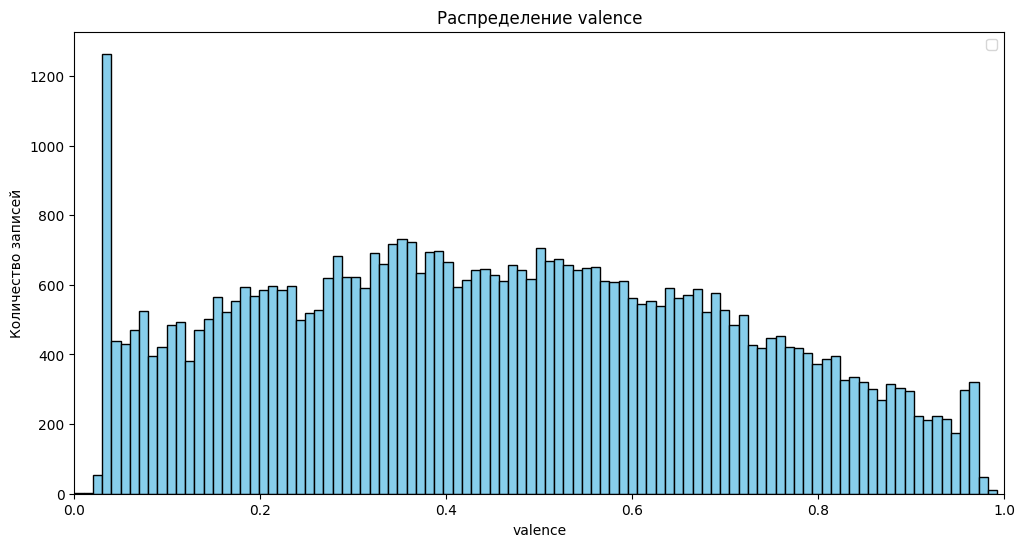

In [ ]:
plt.figure(figsize=(12, 6))

plt.hist(c_df['valence'], bins=100, color='skyblue', edgecolor='black')

plt.title('Распределение valence')
plt.xlabel('valence')
plt.ylabel('Количество записей')
plt.legend()
plt.xlim(0, 1)
plt.show()

Можно заметить, что признак instrumentalness в большинстве своём сильно тяготит к 0

In [ ]:
print(c_df[c_df['instrumentalness'] == 0]['instrumentalness'].shape[0])
print(c_df[c_df['instrumentalness'] >= 0.005]['instrumentalness'].shape[0])

15001
18680


Стоит заменить её на бинарную версию, чтобы убрать бесполезную вариативность

In [26]:
c_df['instrumental_flag'] = (c_df['instrumentalness'] > 0.05).astype(int)
c_df = c_df.drop(columns=['instrumentalness'])

Теперь займёмся обработкой Nan.

In [ ]:
c_df.isna().any()

,0
popularity,False
danceability,False
duration_ms,True
key,False
liveness,False
mode,False
speechiness,False
tempo,True
valence,False
music_genre,False


Для фичи duration_ms можно попробовать заменить Nan медианой. Для фичи tempo Nan является указателем того, что песня не имеет конкретного темпа, что может указывать на некоторые жанры. Попробуем заменить Nan медианой и добавить новую бинарную фичу, указывающую на отсутствие темпа у композиции.

In [27]:
c_df['undefined_tempo'] = c_df['tempo'].isna().astype(int)

median_tempo = c_df['tempo'].median()
c_df['tempo'] = c_df['tempo'].fillna(median_tempo)

median_duration = c_df['duration_ms'].median()
c_df['duration_ms'] = c_df['duration_ms'].fillna(median_duration)

Перейдём к обучению с кросс-валидацей, подбором гиперпараметров и нормализацией

In [28]:
float_features = [
    'popularity', 'danceability', 'duration_ms',
    'liveness', 'speechiness', 'tempo',
    'valence', 'pc1', 'pc2'
]

other_features = [
    'key', 'mode', 'instrumental_flag', 'undefined_tempo'
]

X_c = c_df[float_features + other_features]
y_c = c_df['music_genre']

X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(
    X_c, y_c, test_size=0.2, stratify=y_c, random_state=42
)

In [ ]:
preprocess = ColumnTransformer(
    transformers=[
        ('float_scaling', StandardScaler(), float_features),
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocess', preprocess),
    ('knn', KNeighborsClassifier())
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 15],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'cosine', 'minkowski']
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_c_train, y_c_train)

print("Best parameters:", grid.best_params_)

best_model = grid.best_estimator_

y_c_pred = best_model.predict(X_c_test)
print("Score:", accuracy_score(y_c_test, y_c_pred))

print(classification_report(y_c_test, y_c_pred))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 15, 'knn__weights': 'uniform'}
Score: 0.5073
              precision    recall  f1-score   support

           0       0.31      0.35      0.33      1000
           1       0.72      0.67      0.69      1000
           2       0.54      0.45      0.49      1000
           3       0.77      0.84      0.80      1000
           4       0.43      0.62      0.50      1000
           5       0.63      0.52      0.57      1000
           6       0.40      0.49      0.44      1000
           7       0.53      0.39      0.45      1000
           8       0.35      0.25      0.29      1000
           9       0.47      0.51      0.49      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000



В итоге мы увеличили скор в 3 раза относительно бейзлайна. Относительно небольшой скор вероятнее всего связан с большим количеством групп классификации, небольшим размером датасета, а также с несовершенством KNN.

##### Создание бейзлайна для модели регрессии

Снова начнём с выгрузки данных

In [34]:
r_base_df = pd.read_csv("../regression.csv").sample(frac=1, random_state=42).reset_index(drop=True)
r_base_df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,18,12-03-2010,1138800.32,0,42.39,2.805,131.784000,9.202
1,24,24-06-2011,1304850.67,0,68.88,3.964,135.265267,8.212
2,2,28-10-2011,1769296.25,0,65.87,3.372,217.325182,7.441
3,26,11-11-2011,1077640.13,0,40.08,3.570,136.461806,7.598
4,36,19-03-2010,428851.99,0,59.56,2.701,209.980321,8.554


Просмотрим типы данных датафрейма

In [14]:
r_base_df.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

Т.к. Date представляет собой строку формата DD-MM-YYYY, её следуюет обработать. Разобъём её на признаки

In [35]:
r_base_df['Date'] = pd.to_datetime(r_base_df['Date'], dayfirst=True)

r_base_df["Year"] = r_base_df["Date"].dt.year
r_base_df["Month"] = r_base_df["Date"].dt.month
r_base_df["Day"] = r_base_df["Date"].dt.day

r_base_df = r_base_df.drop(columns=['Date'])

Для соответствия поставленной задаче отсортируем данные по дате

In [36]:
r_base_df = r_base_df.sort_values(
    by=["Year", "Month", "Day", "Store"]
).reset_index(drop=True)

Подготовим данные к обучению и обучим модель на этих данных

In [37]:
per_store_count = r_base_df.groupby('Store').size().iloc[0]
k = max(1, int(np.round(0.8 * per_store_count))) 
store_counts = r_base_df['Store'].nunique()

train = r_base_df.iloc[: store_counts * k]
test = r_base_df.iloc[store_counts * k :]

X_r_base_train = train.drop(columns=['Weekly_Sales'])
X_r_base_test = test.drop(columns=['Weekly_Sales'])
y_r_base_train = train['Weekly_Sales']
y_r_base_test = test['Weekly_Sales']

In [18]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_r_base_train, y_r_base_train)
y_pred = knn.predict(X_r_base_test)

mae = mean_absolute_error(y_r_base_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_r_base_test, y_pred))
r2 = r2_score(y_r_base_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

MAE: 313532.8123678161
RMSE: 445218.7233874716
R2: 0.3037868821841454


##### Улучшение бейзлайна для модели регрессии

Начнём так же с анализа матрици корреляций


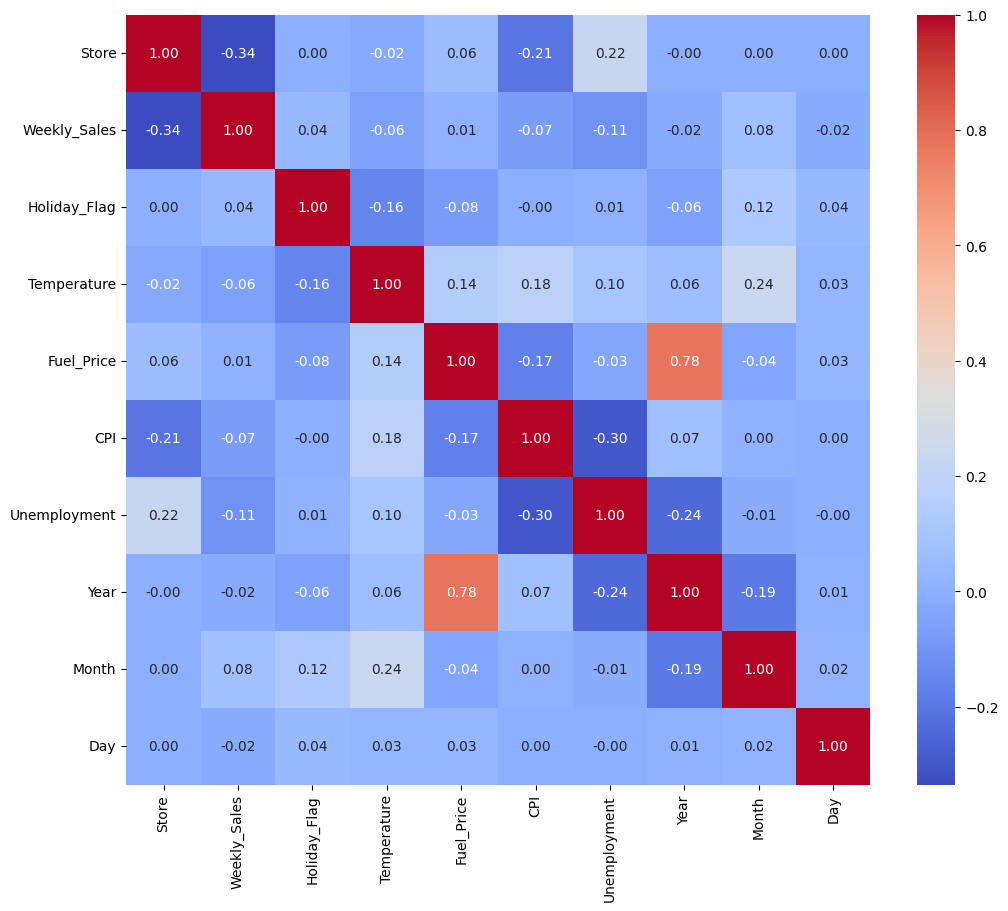

In [19]:
corr_matrix = r_base_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

Видно сильную корреляцию между фичами Year и Fuel_Price. Обе фичи достаточно важны, поэтому убирать какую-то из них не стоит. Но есть другой нюанс: если обратить внимание на корреляцию между целевым признаком и признаками, связанными с датами, можно заметить, что она слабая. Это логично, учитывая то, что в изначальном датасете дата указывает на конкретную неделю, а не на день. Есть смысл удалить фичу с месяцем и днём, но добавить фичу с неделей по счёту.

In [40]:
r_df = pd.read_csv("../regression.csv").sample(frac=1, random_state=42).reset_index(drop=True)

r_df['Date'] = pd.to_datetime(r_df['Date'], dayfirst=True)

r_df['Year'] = r_df['Date'].dt.year
r_df['Week'] = r_df['Date'].dt.isocalendar().week

r_df = r_df.drop(columns=['Date'])

Теперь просмотрим на все фичи

/tmp/ipykernel_795506/306421859.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


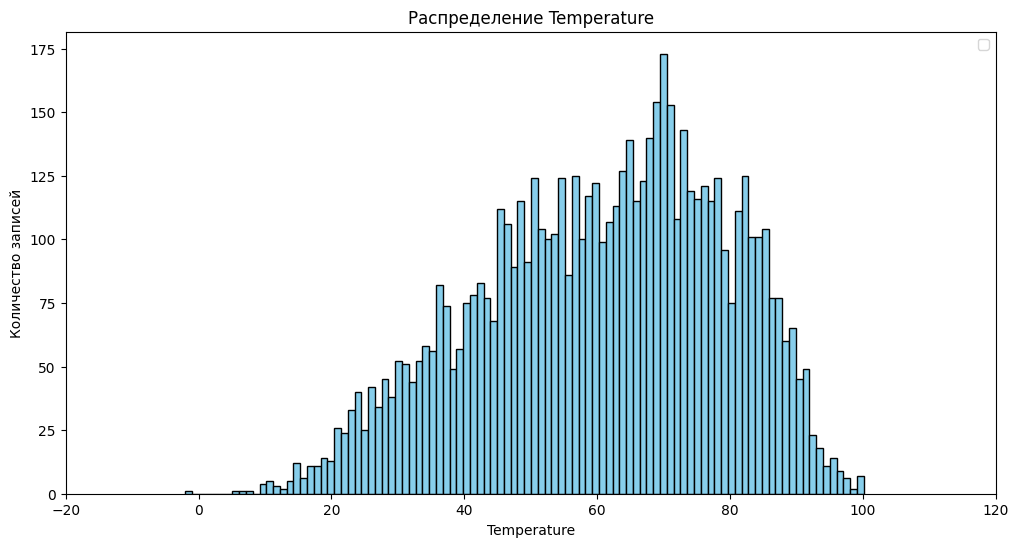

In [25]:
plt.figure(figsize=(12, 6))

plt.hist(r_df['Temperature'], bins=100, color='skyblue', edgecolor='black')

plt.title('Распределение Temperature')
plt.xlabel('Temperature')
plt.ylabel('Количество записей')
plt.legend()
plt.xlim(-20, 120)
plt.show()

/tmp/ipykernel_795506/68046269.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


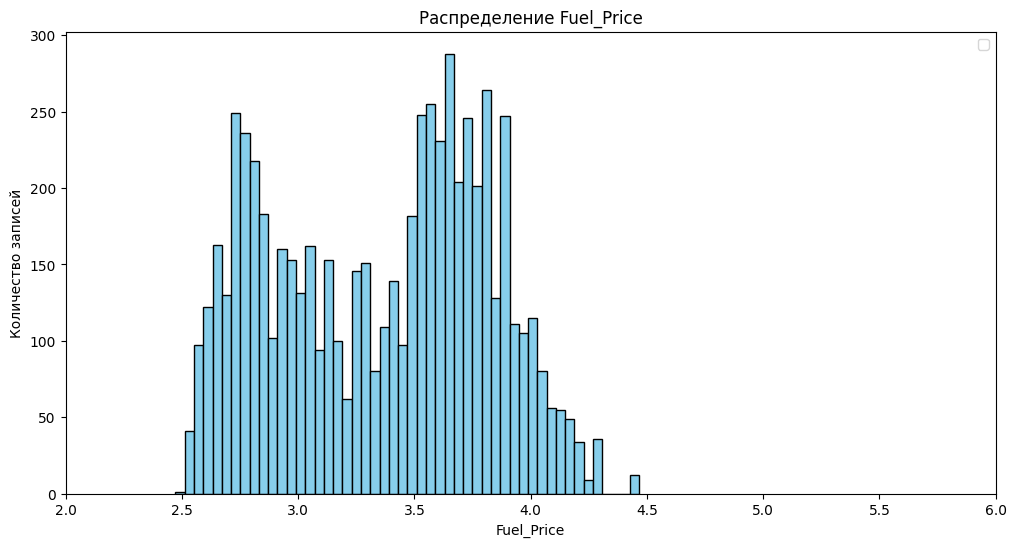

In [26]:
plt.figure(figsize=(12, 6))

plt.hist(r_df['Fuel_Price'], bins=50, color='skyblue', edgecolor='black')

plt.title('Распределение Fuel_Price')
plt.xlabel('Fuel_Price')
plt.ylabel('Количество записей')
plt.legend()
plt.xlim(2, 6)
plt.show()

/tmp/ipykernel_795506/2407202145.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


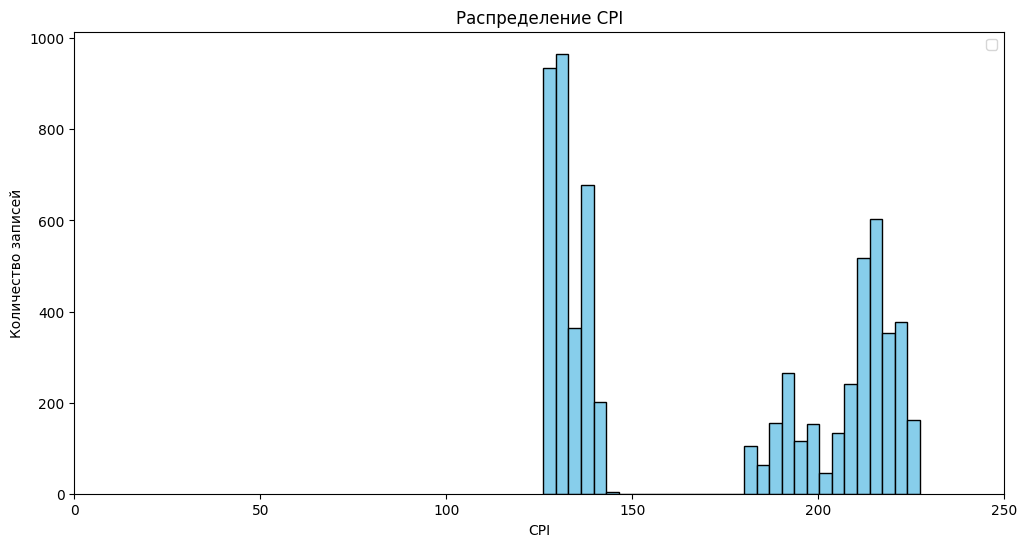

In [27]:
plt.figure(figsize=(12, 6))

plt.hist(r_df['CPI'], bins=30, color='skyblue', edgecolor='black')

plt.title('Распределение CPI')
plt.xlabel('CPI')
plt.ylabel('Количество записей')
plt.legend()
plt.xlim(0, 250)
plt.show()

/tmp/ipykernel_795506/2071780110.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


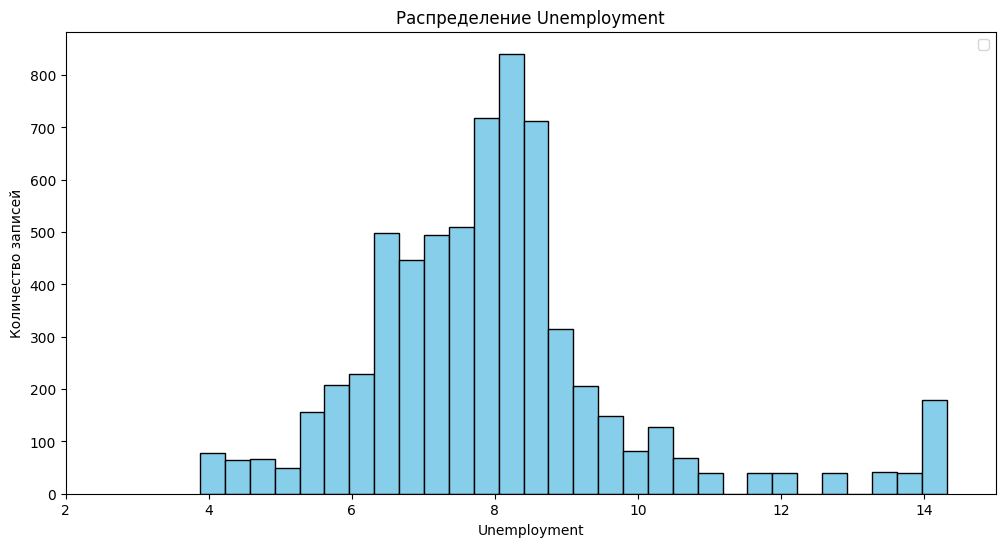

In [28]:
plt.figure(figsize=(12, 6))

plt.hist(r_df['Unemployment'], bins=30, color='skyblue', edgecolor='black')

plt.title('Распределение Unemployment')
plt.xlabel('Unemployment')
plt.ylabel('Количество записей')
plt.legend()
plt.xlim(2, 15)
plt.show()

Теперь перейдём к обучению модели: нормализуем числовые фичи, воспользуемся кросс-валидацией и подбором гиперпараметров

In [41]:
float_features = [
    'Week', 'Year', 'Temperature',
    'Fuel_Price', 'CPI', 'Unemployment'
]

other_features = [
    'Holiday_Flag', 'Store'
]

per_store_count = r_df.groupby('Store').size().iloc[0]
k = max(1, int(np.round(0.8 * per_store_count))) 
store_counts = r_df['Store'].nunique()

train = r_df.iloc[: store_counts * k]
test = r_df.iloc[store_counts * k :]

X_r_train = train.drop(columns=['Weekly_Sales'])
X_r_test = test.drop(columns=['Weekly_Sales'])
y_r_train = train['Weekly_Sales']
y_r_test = test['Weekly_Sales']

In [ ]:
preprocess = ColumnTransformer(
    transformers=[
        ('float_scaling', StandardScaler(), float_features),
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocess', preprocess),
    ('knn', KNeighborsRegressor())
])

cv = KFold(n_splits=5, shuffle=True, random_state=42) # любопытно, что это лучше чем кросс-валидация по группам магазинов

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 15],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'cosine', 'minkowski']
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid.fit(X_r_train, y_r_train)

best_knn = grid.best_estimator_
print("Лучшие параметры:", grid.best_params_)

y_pred = best_knn.predict(X_r_test)

mae = mean_absolute_error(y_r_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_r_test, y_pred))
r2 = r2_score(y_r_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")

Лучшие параметры: {'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}
MAE: 68212.35
RMSE: 129073.03
R2: 0.9485


Посмотрим на полученные метрики вместе со старыми 
| Метрика | Безйлайн | Улучшенная модель |
|-|-|-|
| MAE | 313533 | 68212 |
| RMSE | 4452189 | 129073 |
| R2 | 0.304 | 0.949 |

Модель была сильно улучшена

##### Базовый класс имплементации KNN

In [1]:
class MyKNNBase:
    """
    Базовый класс для KNN 

    Поддерживается:
    - расстояния: euclidean, manhattan
    - веса: uniform, distance
    Я решил не реализовывать остальное, т.к. в предыдущих этапах ЛР я получил лучшие параметры для обучения
    """

    def __init__(
        self,
        n_neighbors=5,
        weights='uniform',
        metric='euclidean',
        eps=1e-8,
        batch_size=256  # Мне не хватило ОЗУ
    ):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
        self.eps = eps
        self.batch_size = batch_size

        # обучающая выборка
        self._fit_X = None
        self._fit_y = None

    def fit(self, X, y):
        """
        Сохраняем обучающие данные.
        """
        self._fit_X = np.asarray(X).copy()
        self._fit_y = np.asarray(y).copy()
        return self

    # Метрики расстояний

    def _euclidean_dists_batch(self, X_batch):
        """
        Евклидово расстояние
        """
        Xb = np.asarray(X_batch)
        Xt = self._fit_X

        xb2 = np.sum(Xb * Xb, axis=1).reshape(-1, 1)
        xt2 = np.sum(Xt * Xt, axis=1).reshape(1, -1)
        cross = Xb.dot(Xt.T)

        d2 = xb2 + xt2 - 2.0 * cross
        d2 = np.maximum(d2, 0.0) 
        return np.sqrt(d2)

    def _manhattan_dists_batch(self, X_batch):
        """
        Манхэттенское расстояние
        """
        Xb = np.asarray(X_batch)
        Xt = self._fit_X
        diff = np.abs(Xb[:, None, :] - Xt[None, :, :])
        return np.sum(diff, axis=2)

    def _compute_distance_batch(self, X_batch):
        """
        Выбор метрики расстояния.
        """
        if self.metric == 'euclidean':
            return self._euclidean_dists_batch(X_batch)
        elif self.metric == 'manhattan':
            return self._manhattan_dists_batch(X_batch)
        else:
            raise ValueError(
                "Unsupported metric: choose 'euclidean' or 'manhattan'"
            )

    # Поиск k ближайших соседей

    def kneighbors(self, X, return_distance=True):
        """
        Находит k ближайших соседей для каждого объекта из X.

        Возвращает:
        - индексы соседей
        - расстояния (опционально)
        """
        if self._fit_X is None:
            raise ValueError("Call fit() before kneighbors()")

        X = np.asarray(X)
        n_test = X.shape[0]
        n_train = self._fit_X.shape[0]
        k = self.n_neighbors

        if k <= 0 or k > n_train:
            raise ValueError("n_neighbors must be between 1 and n_train")

        neigh_idx = np.empty((n_test, k), dtype=int)
        neigh_dists = np.empty((n_test, k), dtype=float)

        batch_size = self.batch_size or n_test

        # считаем расстояния батчами
        for start in range(0, n_test, batch_size):
            end = min(start + batch_size, n_test)
            Xb = X[start:end]

            dists_block = self._compute_distance_batch(Xb)

            # быстрый отбор k минимальных расстояний
            part_idx = np.argpartition(dists_block, kth=k - 1, axis=1)[:, :k]
            part_dists = np.take_along_axis(dists_block, part_idx, axis=1)

            # сортировка внутри k соседей
            order = np.argsort(part_dists, axis=1)
            idx_sorted = np.take_along_axis(part_idx, order, axis=1)
            dists_sorted = np.take_along_axis(part_dists, order, axis=1)

            neigh_idx[start:end] = idx_sorted
            neigh_dists[start:end] = dists_sorted

        if return_distance:
            return neigh_idx, neigh_dists
        return neigh_idx


    def _get_weights(self, distances):
        """
        Возвращает веса для соседей.
        """
        distances = np.asarray(distances)

        if self.weights == 'uniform':
            return np.ones_like(distances)

        if self.weights == 'distance':
            return 1.0 / (distances + self.eps)

        raise ValueError("weights must be 'uniform' or 'distance'")


##### Имплементация KNN для классификации

In [ ]:
class MyKNNClassifier(MyKNNBase):
    def fit(self, X, y):
        super().fit(X, y)
        self.classes_ = np.unique(self._fit_y)
        return self


    def predict(self, X):
        neigh_idx, neigh_dists = self.kneighbors(X, return_distance=True)
        neigh_idx = neigh_idx.astype(int)
        neigh_labels = self._fit_y[neigh_idx]
        weights = self._get_weights(neigh_dists)

        preds = []
        for labels_i, weights_i in zip(neigh_labels, weights):
            score = {}
            for lab, w in zip(labels_i, weights_i):
                score[lab] = score.get(lab, 0) + float(w)
            # Выбираем класс с наибольшим суммарным весом
            # В случае равенства выбирается класс с меньшим значением (x[0])
            best = sorted(score.items(), key=lambda x: (-x[1], x[0]))[0][0]
            preds.append(best)
        return np.array(preds)

Обучим на данных бейзлайна

In [22]:
clf = MyKNNClassifier()
clf.fit(X_c_base_train, y_c_base_train)
preds = clf.predict(X_c_base_test)
acc = accuracy_score(y_c_base_test, preds)
print("Accuracy:", acc)


Accuracy: 0.1737


Обучим на данных улучшенной модели. Сразу будем использовать параметры, полученные при подборе гиперпараметров

In [32]:
preprocess = ColumnTransformer(
    transformers=[
        ('float_scaling', StandardScaler(), float_features),
    ],
    remainder='passthrough'
)

pipeline = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('knn', MyKNNClassifier(  
            n_neighbors=15,
            metric='manhattan',
            batch_size=512
        ))
    ]
)

pipeline.fit(X_c_train, y_c_train)
preds = pipeline.predict(X_c_test)
acc = accuracy_score(y_c_test, preds)
print("Accuracy:", acc)

print(classification_report(y_c_test, preds))

Accuracy: 0.5077
              precision    recall  f1-score   support

           0       0.31      0.35      0.33      1000
           1       0.72      0.67      0.69      1000
           2       0.54      0.45      0.49      1000
           3       0.77      0.84      0.80      1000
           4       0.43      0.62      0.50      1000
           5       0.63      0.52      0.57      1000
           6       0.40      0.49      0.44      1000
           7       0.53      0.39      0.45      1000
           8       0.35      0.26      0.30      1000
           9       0.47      0.51      0.49      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000



В итоге я получил примерно тот же скор, что и модель sklearn

##### Имплементация KNN для регрессии

In [ ]:
class MyKNNRegressor(MyKNNBase):
    def fit(self, X, y):
        super().fit(X, y)
        return self

    def predict(self, X):
        # Получаем индексы и расстояния k ближайших соседей
        neigh_idx, neigh_dists = self.kneighbors(X, return_distance=True)
        neigh_idx = neigh_idx.astype(int)
        neigh_targets = self._fit_y[neigh_idx]  # shape (n_test, k)

        weights = self._get_weights(neigh_dists)  # shape (n_test, k)

        # Средневзвешенное по соседям
        weighted_sum = np.sum(weights * neigh_targets, axis=1)
        sum_weights = np.sum(weights, axis=1)
        # избегаем деления на ноль
        sum_weights[sum_weights == 0] = 1.0
        preds = weighted_sum / sum_weights
        return preds

Обучим на данных бейзлайна

In [38]:
knn = MyKNNRegressor()
knn.fit(X_r_base_train, y_r_base_train)
y_pred = knn.predict(X_r_base_test)

mae = mean_absolute_error(y_r_base_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_r_base_test, y_pred))
r2 = r2_score(y_r_base_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

MAE: 313532.8123678161
RMSE: 445218.7233874716
R2: 0.3037868821841454


Обучим на данных улучшенной модели. Сразу будем использовать параметры, полученные при подборе гиперпараметров

In [52]:
preprocess = ColumnTransformer(
    transformers=[
        ('float_scaling', StandardScaler(), float_features),
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocess', preprocess),
    ('knn', MyKNNRegressor(weights='distance'))
])

pipeline.fit(X_r_train, y_r_train)
y_pred = pipeline.predict(X_r_test)

mae = mean_absolute_error(y_r_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_r_test, y_pred))
r2 = r2_score(y_r_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

MAE: 68212.35146237123
RMSE: 129073.03082267479
R2: 0.9485055883120729


/home/demagog/IT/MAI-AI-FRAMEWORKS/venv/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Опять же, всё то же самое, что и у sklearn. Это логично, KNN достаточно простой и однозначный алгоритм